In [1]:
import time
import numpy as np
import scipy
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import paxplot
import pickle
from functools import partial

In [2]:
with open("data/sim_long_preprocessed_slice.pkl", "rb") as file:
    import_dict = pickle.load(file)
import_dict.keys()

dict_keys(['parameters', 'patterns'])

(128, 128)

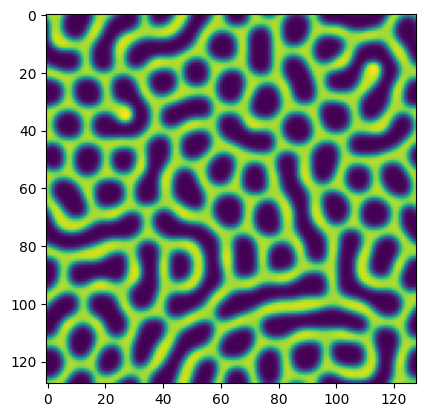

In [3]:
test_pattern = import_dict["patterns"][0]#[::2, ::2]
plt.imshow(test_pattern)
test_pattern.shape

In [4]:
def get_adj_matrix_slow(pattern, eps=0.003):
    assert pattern.shape[0] == pattern.shape[1]
    graph_res = pattern.shape[0]
    m = graph_res**2

    adj_matrix = np.zeros((m, m), dtype=np.float64)
    u_mean = np.mean(pattern)

    for i in range(m):
        neighbor_js = np.array([i - 1, i + 1, i - graph_res, i + graph_res])
        neighbor_js = neighbor_js % m

        for j in neighbor_js:
            u_vi = pattern[i % graph_res, i // graph_res]
            u_vj = pattern[j % graph_res, j // graph_res]
            vi_high = u_vi > u_mean
            vj_high = u_vj > u_mean
            if not vi_high ^ vj_high:  # both on same side of u_mean
                adj_matrix[i, j] = 1
            else:
                adj_matrix[i, j] = eps

    return adj_matrix

def compute_resistance_slow(pattern, eps):
    assert pattern.shape[0] == pattern.shape[1]
    graph_res = pattern.shape[0]
    m = graph_res**2

    adj_matrix = get_adj_matrix_slow(pattern, eps)
    graph_laplacian = np.diag(adj_matrix @ np.ones((m,))) - adj_matrix
    K = scipy.linalg.inv(np.ones((m, m)) + graph_laplacian)
    Kvivi = np.ones((m, m)) * np.diagonal(K)[:, None]
    Kvjvj = Kvivi.T
    resistance = Kvivi + Kvjvj - 2 * K

    assert resistance.shape == (m, m)

    return resistance

eps = 0.003

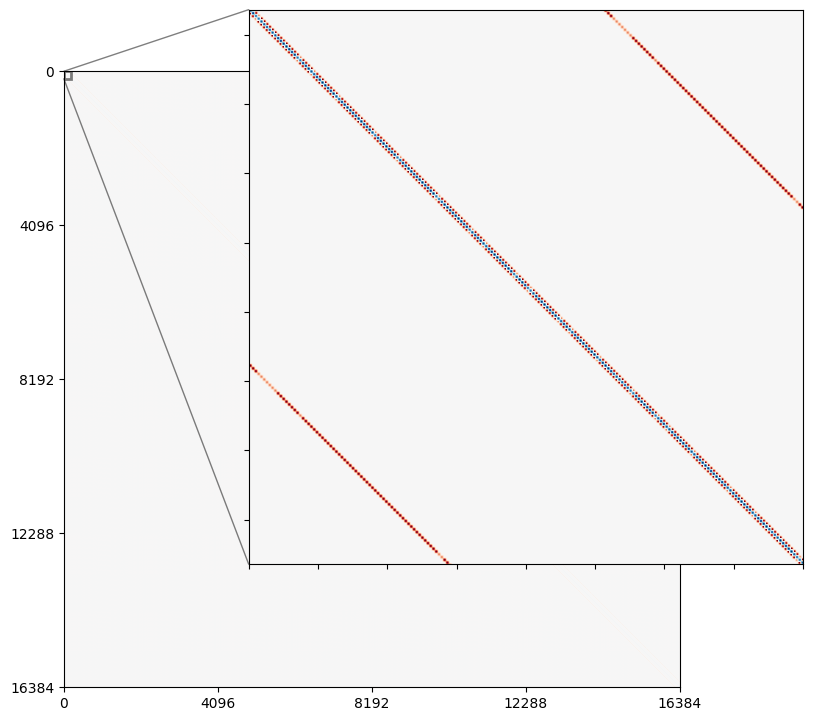

In [5]:
#| label: fig-laplacian
#| fig-cap: "Graph Laplacian matrix. Positive diagonal and negative off-diagonals. The crucial information, impacting e.g. the resistance distance, lies in the variation inside the 7 non-zero bands."

fig, ax = plt.subplots(figsize=(8,8), dpi=100)

adj_matrix = get_adj_matrix_slow(test_pattern, 0.5)
m = adj_matrix.shape[0]
Z = graph_laplacian = np.diag(adj_matrix @ np.ones((m,))) - adj_matrix

extent = (0,m,0,m)

divnorm=mpl.colors.TwoSlopeNorm(vcenter=0., vmin=Z.min(), vmax=Z.max())
img = ax.imshow(Z, origin="upper", extent=extent, cmap="RdBu", norm=divnorm)
ticks = [0, 1*m//4, m//2, 3*m//4, m]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)
ax.set_yticks(ticks)
ax.set_yticklabels(ticks[::-1])

crop_size = 200

# inset Axes....
x1, x2, y1, y2 = 0,crop_size,m-crop_size,m  # subregion of the original image
axins = ax.inset_axes(
    [0.3, 0.2, 0.9, 0.9],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
axins.imshow(Z, origin="upper", extent=extent, cmap="RdBu", norm=divnorm)

ax.indicate_inset_zoom(axins, edgecolor="black", lw=2)

plt.show()

In [6]:
test_pattern = import_dict["patterns"][0][:30:2, :30:2]

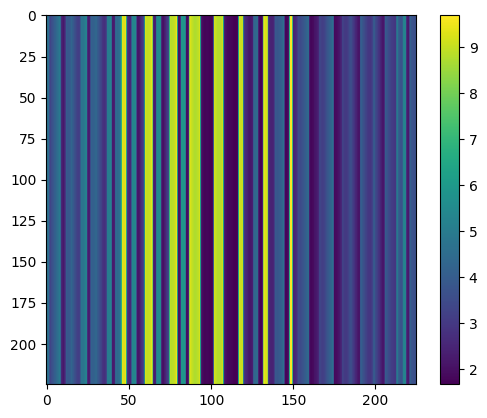

In [7]:
graph_res = test_pattern.shape[0]
m = graph_res**2
adj_matrix = get_adj_matrix_slow(test_pattern, eps)
graph_laplacian = np.diag(adj_matrix @ np.ones((m,))) - adj_matrix
K = scipy.linalg.inv(np.ones((m, m)) + graph_laplacian)
Kvivi = np.ones((m, m)) * np.diagonal(K)[:, None]
Kvjvj = Kvivi.T
plt.imshow(Kvjvj)
plt.colorbar()

In [8]:
t1 = time.time()
res_dist = compute_resistance_slow(test_pattern, eps);
time_reference = time.time() - t1
f"took {time_reference:.4f}s"  #   | mean={np.mean(res_dist_reference):.4f}"

'took 0.1246s'

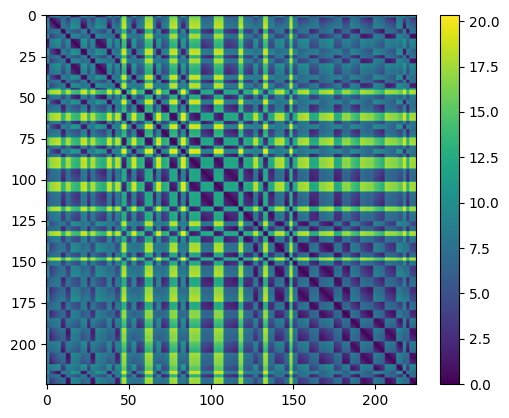

In [9]:
plt.imshow(res_dist)
plt.colorbar();

In [10]:
def prepare_graph_laplacian_matrix(pattern, eps):
    graph_res = pattern.shape[0]
    m = graph_res**2

    adj_matrix = get_adj_matrix_slow(pattern, eps)
    graph_laplacian = np.diag(adj_matrix @ np.ones((m,))) - adj_matrix
    return graph_laplacian

laplacian = prepare_graph_laplacian_matrix(test_pattern, eps)

# K = scipy.linalg.inv(np.ones((m, m)) + graph_laplacian)

In [11]:
%%timeit
scipy.linalg.pinv(laplacian)

142 ms ± 6.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
generalized_inverse = scipy.linalg.pinv(laplacian)

In [13]:
def check_g_inverse(A, G):
    return np.isclose(A @ G @ A, A).mean() == 1.0

check_g_inverse(laplacian, generalized_inverse)

True

In [14]:
def benchmark_g_inv_fun(A, fun, num_loops=3):

    t1 = time.time()
    for i in range(num_loops):
        G = fun(A)
    t_total = time.time() - t1
    assert check_g_inverse(A, G), "The provided function did not compute a correct g-inverse."
    return t_total / num_loops

In [15]:
laplacian.shape

(225, 225)

In [16]:
benchmark_g_inv_fun(laplacian, np.linalg.pinv)

0.025146484375

In [17]:
benchmark_g_inv_fun(laplacian, scipy.linalg.pinv)

0.13741509119669595

In [18]:
def imqrginv(a: np.ndarray) -> np.ndarray:
    q, r = np.linalg.qr(a, mode="reduced")
    return r.transpose(1, 0).conj() @ np.linalg.inv(r @ r.transpose(1, 0).conj()) @ q.transpose(1, 0).conj()

benchmark_g_inv_fun(laplacian, np.linalg.pinv)

0.038936456044514976

In [19]:
def add_ones_before_fun(A, fun):
    return fun(np.ones_like(A) + A)
maybe_g_inv = add_ones_before_fun(laplacian, np.linalg.inv)
assert check_g_inverse(laplacian, maybe_g_inv)

In [20]:
benchmark_g_inv_fun(laplacian, partial(add_ones_before_fun, fun=np.linalg.inv))

0.0011440118153889973

In [21]:
benchmark_g_inv_fun(laplacian, partial(add_ones_before_fun, fun=np.linalg.pinv))

0.009821097056070963

In [22]:
g_inv_funs = {
    "+1-np-inv": partial(add_ones_before_fun, fun=np.linalg.inv),
    "+1-scipy-inv": partial(add_ones_before_fun, fun=scipy.linalg.inv),
    "np-pinv": np.linalg.pinv,
    "scipy-pinv": scipy.linalg.pinv,
    "np-pinvh": partial(np.linalg.pinv, hermitian=True),
    "scipy-pinvh": scipy.linalg.pinvh,
}
results_small_m = {}
for pattern_size in [8, 16, 32, 64]:
    test_pattern = import_dict["patterns"][0][:pattern_size, :pattern_size]
    laplacian = prepare_graph_laplacian_matrix(test_pattern, eps)
    m = laplacian.shape[0]
    print(f"graph has {m} vertices.")
    results_small_m[m] = {}
    for key, fun in g_inv_funs.items():
        if "+1" in key:  # repeat the faster algorithms a bit more often to reduce sampling error
            if pattern_size < 30:
                num_loops = 50
            else:
                num_loops = 20
        else:
            if pattern_size < 30:
                num_loops = 20
            else:
                num_loops = 8
        elapsed = benchmark_g_inv_fun(laplacian, fun, num_loops=num_loops)
        print(elapsed, key)
        results_small_m[m][key] = elapsed

graph has 64 vertices.
0.00011413097381591797 +1-np-inv
0.00014008522033691405 +1-scipy-inv
0.0012161016464233398 np-pinv
0.008746886253356933 scipy-pinv
0.002484130859375 np-pinvh
0.0036941170692443848 scipy-pinvh
graph has 256 vertices.
0.00465179443359375 +1-np-inv
0.00352142333984375 +1-scipy-inv
0.025093352794647215 np-pinv
0.16102132797241211 scipy-pinv
0.019651973247528078 np-pinvh
0.18433376550674438 scipy-pinvh
graph has 1024 vertices.
0.05806041955947876 +1-np-inv
0.06515189409255981 +1-scipy-inv
0.575680673122406 np-pinv
0.7435911595821381 scipy-pinv
0.20940321683883667 np-pinvh
0.9509794414043427 scipy-pinvh
graph has 4096 vertices.
2.1050000548362733 +1-np-inv
3.566044104099274 +1-scipy-inv
31.111353754997253 np-pinv
34.37004932761192 scipy-pinv
13.204486846923828 np-pinvh
69.60303673148155 scipy-pinvh


In [23]:
import warnings
warnings.filterwarnings("ignore", message="^.*is not officially supported by Paxplot, but it may still work.*$")

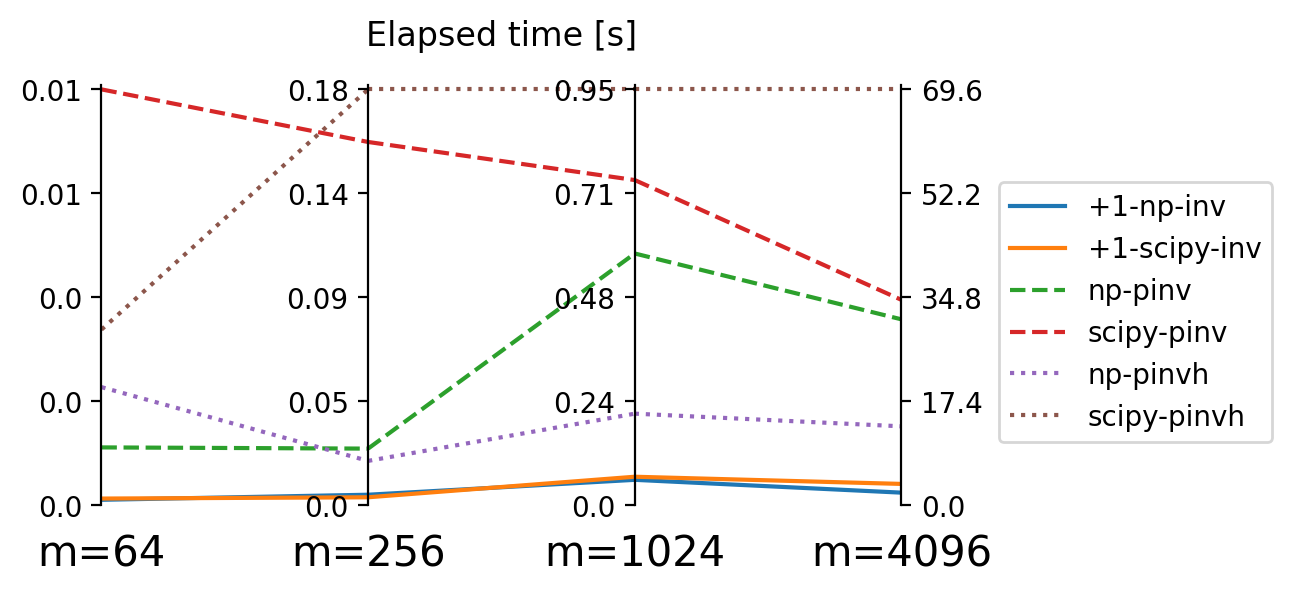

In [24]:
#| label: fig-np-scipy-1inv-pinv
#| fig-cap: "Parallel coordinate view of different methods accross low to medium matrix sizes $m$. '+1 trick' outperforms Moore-Penrose inverse. No clear winner between `numpy` and `scipy` accross matrix size $m$."

res_df = pd.DataFrame(results_small_m)
cols = res_df.columns
col_names = ["m="+str(col) for col in cols]

# Create figure
paxfig = paxplot.pax_parallel(n_axes=len(cols))
paxfig.plot(res_df.to_numpy()[:2,], line_kwargs={"linestyle": "-"})
paxfig.plot(res_df.to_numpy()[2:4], line_kwargs={"linestyle": "--"})
paxfig.plot(res_df.to_numpy()[-2:], line_kwargs={"linestyle": ":"})
paxfig.set_labels(col_names)
plt.suptitle("Elapsed time [s]", y=1.01)

# Changing figure size
paxfig.set_size_inches(5, 3)
paxfig.set_dpi(200)
paxfig.subplots_adjust(left=0.1, bottom=0.2, right=0.9, top=0.9)  # Padding

# Change tick size
tick_size = 10
for ax in paxfig.axes:
    ax.tick_params(axis="y", labelsize=tick_size)

# Change label size
label_size = 15
for ax in paxfig.axes:
    ax.tick_params(axis="x", labelsize=label_size)


for i, m in enumerate(cols):
    max_tick = res_df[m].max()
    paxfig.set_lim(i, 0,  max_tick * 1.01)
    paxfig.set_even_ticks(
        ax_idx=i,
        n_ticks=4,
        minimum=0,
        maximum=max_tick,
    )

lines = paxfig.axes[0].lines
labels = [i for i in res_df.index]
plt.legend(lines, labels, bbox_to_anchor=(1.5, 1),
                         loc='upper left', borderaxespad=3.5);

In [25]:
g_inv_funs = {
    "+1-np-inv": partial(add_ones_before_fun, fun=np.linalg.inv),
    "+1-scipy-inv": partial(add_ones_before_fun, fun=scipy.linalg.inv),
}
results_large_m = {}
for pattern_size in [16, 32, 64, 128]:
    test_pattern = import_dict["patterns"][0][:pattern_size, :pattern_size]
    laplacian = prepare_graph_laplacian_matrix(test_pattern, eps)
    m = laplacian.shape[0]
    print(f"graph has {m} vertices.")
    results_large_m[m] = {}
    for key, fun in g_inv_funs.items():
        elapsed = benchmark_g_inv_fun(laplacian, fun, num_loops=3)
        print(elapsed, key)
        results_large_m[m][key] = elapsed

graph has 256 vertices.
0.0024029413859049478 +1-np-inv
0.041563828786214195 +1-scipy-inv
graph has 1024 vertices.
0.546661376953125 +1-np-inv
0.06827251116434734 +1-scipy-inv
graph has 4096 vertices.
2.0935885111490884 +1-np-inv
1.9664779504140217 +1-scipy-inv
graph has 16384 vertices.
82.14190308252971 +1-np-inv
99.59056385358174 +1-scipy-inv


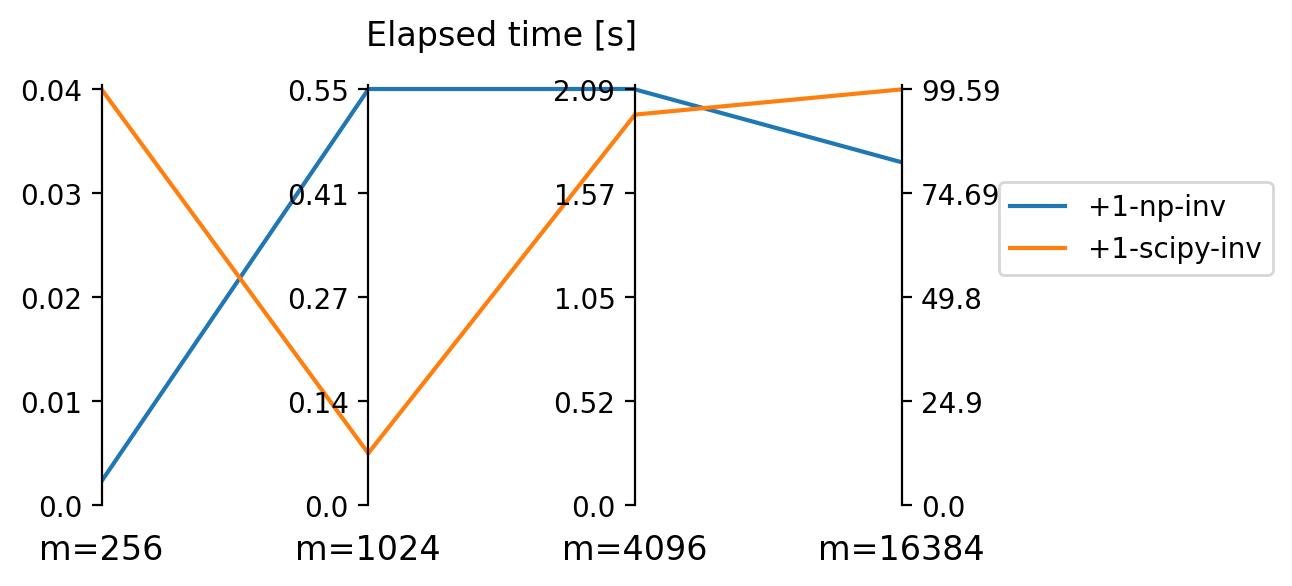

In [26]:
#| label: fig-np-scipy-1inv-high-m
#| fig-cap: "Parallel coordinate view of different methods accross low to high matrix sizes $m$. No clear winner between `numpy` and `scipy` for very high matrix size $m$."

res_df = pd.DataFrame(results_large_m)
cols = res_df.columns
col_names = ["m="+str(col) for col in cols]

# Create figure
paxfig = paxplot.pax_parallel(n_axes=len(cols))
paxfig.plot(res_df.to_numpy(), line_kwargs={"linestyle": "-"})
paxfig.set_labels(col_names)
plt.suptitle("Elapsed time [s]", y=1.01)

# Changing figure size
paxfig.set_size_inches(5, 3)
paxfig.set_dpi(200)
paxfig.subplots_adjust(left=0.1, bottom=0.2, right=0.9, top=0.9)  # Padding

# Change tick size
tick_size = 10
for ax in paxfig.axes:
    ax.tick_params(axis="y", labelsize=tick_size)

# Change label size
label_size = 12
for ax in paxfig.axes:
    ax.tick_params(axis="x", labelsize=label_size)


for i, m in enumerate(cols):
    max_tick = res_df[m].max()
    paxfig.set_lim(i, 0,  max_tick * 1.01)
    paxfig.set_even_ticks(
        ax_idx=i,
        n_ticks=4,
        minimum=0,
        maximum=max_tick,
    )

lines = paxfig.axes[0].lines
labels = [i for i in res_df.index]
plt.legend(lines, labels, bbox_to_anchor=(1.5, 1),
                         loc='upper left', borderaxespad=3.5);